# Imports

In [ ]:
# Imports
from google.colab import drive
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage.feature import hog
from skimage import exposure
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier



In [ ]:
# Retrieving the data
drive.mount('/content/gdrive')

# Get all paths
covid_path = '/content/gdrive/MyDrive/CSC3009 Machine Learning Team 15/dataset_15/covid'
normal_path = '/content/gdrive/MyDrive/CSC3009 Machine Learning Team 15/dataset_15/normal'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Statistical Analysis

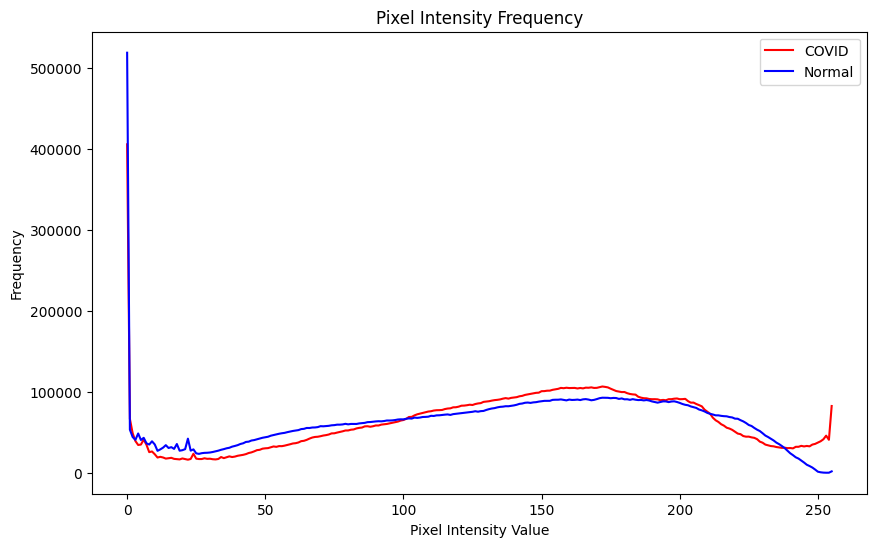

In [ ]:
def calculate_pixel_intensity_frequency(image_path, num_images):
    pixel_frequency = [0] * 256
    count = 0

    for filename in os.listdir(image_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image = cv2.imread(os.path.join(image_path, filename), cv2.IMREAD_GRAYSCALE)
            for pixel_value in image.ravel():
                pixel_frequency[pixel_value] += 1

            count += 1
            if count >= num_images:
                break

    return pixel_frequency

def plot_pixel_intensity_frequency(covid_frequency, normal_frequency):
    plt.figure(figsize=(10, 6))
    plt.plot(range(256), covid_frequency, label='COVID', color='red')
    plt.plot(range(256), normal_frequency, label='Normal', color='blue')
    plt.title("Pixel Intensity Frequency")
    plt.xlabel("Pixel Intensity Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Calculate frequency for COVID images (taking only 180 images)
covid_frequency = calculate_pixel_intensity_frequency(covid_path, num_images=180)

# Calculate frequency for normal images (taking only 180 images)
normal_frequency = calculate_pixel_intensity_frequency(normal_path, num_images=180)

# Plot frequency graph with both results on the same graph
plot_pixel_intensity_frequency(covid_frequency, normal_frequency)

In [ ]:
def stats(directory):
    image_files = [file for file in os.listdir(directory)]
    num_images = len(image_files)
    pixel_sum = 0
    highest_pixel_value = 0
    lowest_pixel_value = 255

    for image_file in image_files:
        image_path = os.path.join(directory, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        pixel_sum += np.sum(image)
        highest_pixel_value = max(highest_pixel_value, np.max(image))
        lowest_pixel_value = min(lowest_pixel_value, np.min(image))


    average_pixel_value = pixel_sum / (num_images * image.shape[0] * image.shape[1])
    pixel_var = 0

    for image_file in image_files:
        image_path = os.path.join(directory, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        pixel_var += np.sum((image - average_pixel_value) ** 2)

    pixel_std_dev = np.sqrt(pixel_var / (num_images * image.shape[0] * image.shape[1]))

    return average_pixel_value, pixel_std_dev, highest_pixel_value, lowest_pixel_value

average_pixel_covid, pixel_std_dev_covid, highest_pixel_covid, lowest_pixel_covid = stats(covid_path)
average_pixel_normal, pixel_std_dev_normal, highest_pixel_normal, lowest_pixel_normal = stats(normal_path)

print("Average Pixel Value (COVID):", average_pixel_covid)
print("Standard Deviation (COVID):", pixel_std_dev_covid)
print("Highest Pixel Value (COVID):", highest_pixel_covid)
print("Lowest Pixel Value (COVID):", lowest_pixel_covid)

print("Average Pixel Value (Normal):", average_pixel_normal)
print("Standard Deviation (Normal):", pixel_std_dev_normal)
print("Highest Pixel Value (Normal):", highest_pixel_normal)
print("Lowest Pixel Value (Normal):", lowest_pixel_normal)

Average Pixel Value (COVID): 140.33026227645973
Standard Deviation (COVID): 62.61530363568596
Highest Pixel Value (COVID): 255
Lowest Pixel Value (COVID): 0
Average Pixel Value (Normal): 130.54882025928123
Standard Deviation (Normal): 65.24805796530575
Highest Pixel Value (Normal): 255
Lowest Pixel Value (Normal): 0


Covid Affected Lungs
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)


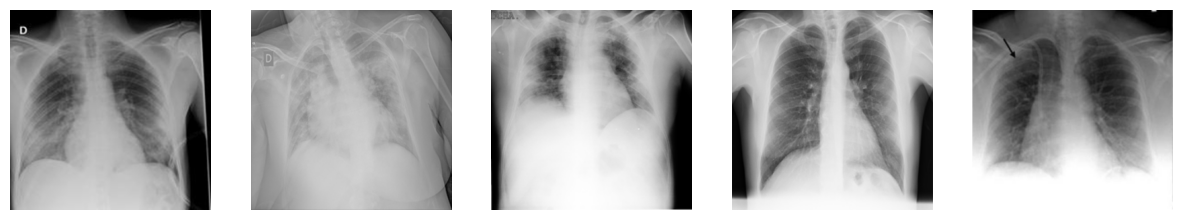

Unaffected Lungs
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)
(299, 299, 3)


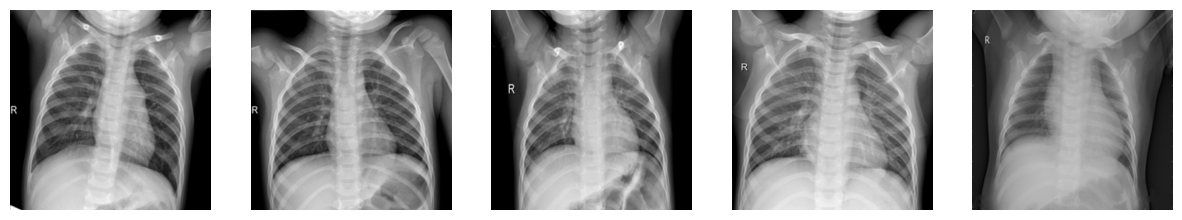

In [ ]:
def display_top_images(directory):
    # Get a list of image files in the directory
    image_files = [file for file in os.listdir(directory)]

    # Sort the image files based on file creation time (you can change this based on your requirement)
    sorted_files = sorted(image_files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)

    # Display the top images
    plt.figure(figsize=(15, 5))
    for i in range(5):
        img_path = os.path.join(directory, sorted_files[i])
        img = cv2.imread(img_path)
        print(img.shape)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

print("Covid Affected Lungs")
display_top_images(covid_path)

print("Unaffected Lungs")
display_top_images(normal_path)

# Functions

In [ ]:
# Image retrieval function
def image_extraction(image_folder_path, grayscale, flatten_it,reshape_it):
  images = []
  image_files = os.listdir(image_folder_path)
  for image_file in image_files:

      image_path = os.path.join(image_folder_path, image_file)
      # Load and resize the image
      img = Image.open(image_path)  # Resize to a common size, e.g., 100x100

      if reshape_it == 1:
       img = img.resize((299,299))


      if grayscale == 1:
         img = img.convert('L')

      # Convert the image to a numerical array
      img_array = np.array(img)

      # Normalize the pixel values
      img_array = img_array / 255.0

      # Optionally flatten the array (if needed for the model)
      if flatten_it == 1:
        img_array = img_array.flatten()

      # Append the numerical array and label to the lists
      images.append(img_array)

  return images

def hogify(images):
  hog_features = []
  for image in images:
    # Adjust the parameters as per your requirement
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    hog_features.append(features)
  return hog_features


def siftify(image_folder_path):
    images = []
    image_files = os.listdir(image_folder_path)
    sift = cv2.SIFT_create()
    sift_descriptors = []
    for img in image_files:
        image_path = os.path.join(image_folder_path, img)
        # Read the image in grayscale
        gray_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Ensure the image is in uint8 format
        if gray_img.dtype != 'uint8':
            gray_img = cv2.convertScaleAbs(gray_img)

        # Detect keypoints and compute descriptors using SIFT
        keypoints, descriptors = sift.detectAndCompute(gray_img, None)
        # Store the SIFT descriptors for each image
        sift_descriptors.append(descriptors)

    return sift_descriptors

def svm_classifier(dataset, labels, hogify_flag, kernel):
  model = SVC(kernel=kernel, probability=True)
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  fold_metrics = {
      'accuracy': [],
      'loss': [],
      'confusion_matrix': []
  }

  dataset = dataset
  if hogify_flag == 1:
    dataset = np.array(dataset)

  for train_index, test_index in kf.split(dataset):
      X_train, X_test = dataset[train_index], dataset[test_index]
      y_train, y_test = labels[train_index], labels[test_index]

      # Train the model on the training data
      model.fit(X_train, y_train)

      # Make predictions on the testing data
      y_pred = model.predict(X_test)
      y_prob = model.predict_proba(X_test)  # For log loss calculation

      # Calculate the accuracy of the model for this fold
      accuracy = accuracy_score(y_test, y_pred)
      fold_metrics['accuracy'].append(accuracy)

      # Calculate the log loss of the model for this fold
      logloss = log_loss(y_test, y_prob)
      fold_metrics['loss'].append(logloss)

      # Calculate the confusion matrix for this fold
      cm = confusion_matrix(y_test, y_pred)
      fold_metrics['confusion_matrix'].append(cm)

  # Calculate the average metrics over all folds
  average_accuracy = np.mean(fold_metrics['accuracy'])
  average_logloss = np.mean(fold_metrics['loss'])
  average_confusion_matrix = sum(fold_metrics['confusion_matrix'])

  # Print the average metrics
  print("Average Accuracy: {:.2f}%".format(average_accuracy * 100))
  print("Average Loss: {:.4f}".format(average_logloss))
  print("Average Confusion Matrix:")
  print(average_confusion_matrix)

# Image Extraction

In [ ]:
images_covid = image_extraction(covid_path,0,1,0)
images_normal = image_extraction(normal_path,0,1,0)

images_covid_cropped =image_extraction(covid_cropped_path,0,1,0)
images_normal_cropped = image_extraction(normal_cropped_path,0,1,0)

dataset = np.concatenate((images_covid, images_normal), axis=0)
labels = np.concatenate((np.ones(len(images_covid)), np.zeros(len(images_normal))), axis=0)

dataset_cropped = np.concatenate((images_covid_cropped, images_normal_cropped), axis=0)
labels_cropped = np.concatenate((np.ones(len(images_covid_cropped)), np.zeros(len(images_normal_cropped))), axis=0)

# For use with HOG
images_covid_1 = image_extraction(covid_path,1,0,0)
images_normal_1 = image_extraction(normal_path,1,0,0)

images_covid_cropped_1 =image_extraction(covid_cropped_path,1,0,0)
images_normal_cropped_1 = image_extraction(normal_cropped_path,1,0,0)

dataset_1 = np.concatenate((images_covid_1, images_normal_1), axis=0)
dataset_hog = hogify(dataset_1)
labels_hog = np.concatenate((np.ones(len(images_covid_1)), np.zeros(len(images_normal_1))), axis=0)

dataset_cropped_1 = np.concatenate((images_covid_cropped_1, images_normal_cropped_1), axis=0)
dataset_cropped_hog = hogify(dataset_cropped_1)
labels_cropped_hog = np.concatenate((np.ones(len(images_covid_cropped_1)), np.zeros(len(images_normal_cropped_1))), axis=0)

In [ ]:
# For use with SIFT
images_covid_2 = image_extraction(covid_path,1,0,0)
images_normal_2 = image_extraction(normal_path,1,0,0)
dataset_2 = np.concatenate((images_covid_2, images_normal_2), axis=0)

images_covid_cropped_2 =image_extraction(covid_cropped_path,1,0,0)
images_normal_cropped_2 = image_extraction(normal_cropped_path,1,0,0)
dataset_cropped_2 = np.concatenate((images_covid_cropped_2, images_normal_cropped_2), axis=0)

In [ ]:
dataset_sift = siftify('/content/gdrive/MyDrive/CSC3009 Machine Learning Team 15/dataset_15/covid')
labels_sift = np.concatenate((np.ones(len(images_covid_2)), np.zeros(len(images_normal_2))), axis=0)


images_covid_sift = siftify(covid_path)
images_normal_sift = siftify(normal_path)

images_covid_cropped_sift =siftify(covid_cropped_path)
images_normal_cropped_sift = siftify(normal_cropped_path)

dataset_sift = np.concatenate((images_covid, images_normal), axis=0)
labels_sift = np.concatenate((np.ones(len(images_covid)), np.zeros(len(images_normal))), axis=0)

dataset_cropped_sift = np.concatenate((images_covid_cropped, images_normal_cropped), axis=0)
labels_cropped_sift = np.concatenate((np.ones(len(images_covid_cropped)), np.zeros(len(images_normal_cropped))), axis=0)

# HOG Visualisation

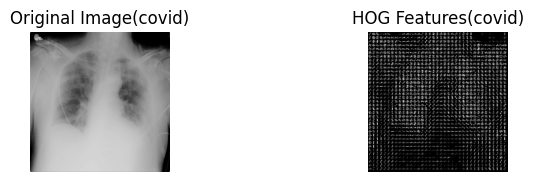

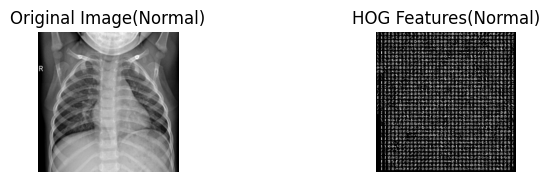

In [ ]:
# Example of Using HOG on an unaffected and covid lung

covid_lung_image = cv2.imread('/content/gdrive/MyDrive/CSC3009 Machine Learning Team 15/dataset_15/covid/COVID-1.png', cv2.IMREAD_GRAYSCALE)
unaffected_lung_image = cv2.imread('/content/gdrive/MyDrive/CSC3009 Machine Learning Team 15/dataset_15/normal/Normal-1063.png', cv2.IMREAD_GRAYSCALE)

# Rescale HOG image to 0-255 range

hog_features_covid, hog_image_covid = hog(covid_lung_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
hog_features_unaffected, hog_image_unaffected = hog(unaffected_lung_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
hog_image_covid = hog_image_covid * 255
hog_image_covid = hog_image_covid.astype(np.uint8)
hog_image_unaffected = hog_image_unaffected * 255
hog_image_unaffected = hog_image_unaffected.astype(np.uint8)

# Display the original image and HOG image
plt.figure(figsize=(8, 4))
plt.subplot(2, 2, 1)
plt.imshow(covid_lung_image, cmap='gray')
plt.title('Original Image(covid)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(hog_image_covid, cmap='gray')
plt.title('HOG Features(covid)')
plt.axis('off')

# Display the original image and HOG image
plt.figure(figsize=(8, 4))
plt.subplot(2, 2, 3)
plt.imshow(unaffected_lung_image, cmap='gray')
plt.title('Original Image(Normal)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(hog_image_unaffected, cmap='gray')
plt.title('HOG Features(Normal)')
plt.axis('off')

plt.show()

# SIFT Visualisation

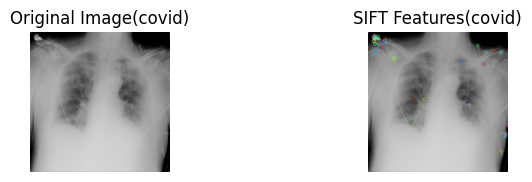

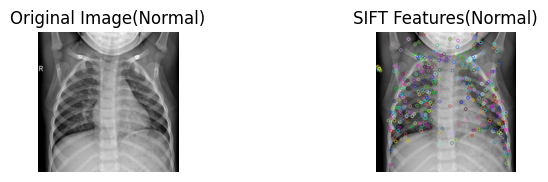

In [ ]:
def visualize_sift_image(image, keypoints):

    # Convert the image to RGB format (OpenCV uses BGR by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Draw keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image_rgb, keypoints, None)

    # Display the image
    return  image_with_keypoints

# Read the image
covid_lung_image = cv2.imread('/content/gdrive/MyDrive/CSC3009 Machine Learning Team 15/dataset_15/covid/COVID-1.png', cv2.IMREAD_GRAYSCALE)
unaffected_lung_image = cv2.imread('/content/gdrive/MyDrive/CSC3009 Machine Learning Team 15/dataset_15/normal/Normal-1063.png', cv2.IMREAD_GRAYSCALE)

# Create SIFT object and detect keypoints
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(covid_lung_image, None)
sift_image_covid = visualize_sift_image(covid_lung_image, keypoints)

sift1 = cv2.SIFT_create()
keypoints, descriptors = sift1.detectAndCompute(unaffected_lung_image, None)
sift_image_unaffected = visualize_sift_image(unaffected_lung_image, keypoints)


# Display the original image and HOG image
plt.figure(figsize=(8, 4))
plt.subplot(2, 2, 1)
plt.imshow(covid_lung_image, cmap='gray')
plt.title('Original Image(covid)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(sift_image_covid, cmap='gray')
plt.title('SIFT Features(covid)')
plt.axis('off')

# Display the original image and HOG image
plt.figure(figsize=(8, 4))
plt.subplot(2, 2, 3)
plt.imshow(unaffected_lung_image, cmap='gray')
plt.title('Original Image(Normal)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(sift_image_unaffected, cmap='gray')
plt.title('SIFT Features(Normal)')
plt.axis('off')

plt.show()

# SVM Classification

In [ ]:
#Linear
print("\nUncropped No Hog Processing:")
svm_classifier(dataset, labels,0, "linear")
print("\ncropped No Hog Processing")
svm_classifier(dataset_cropped, labels_cropped,0,"linear")
print("\nUncropped Hog Processing")
svm_classifier(dataset_hog, labels_hog, 1,"linear")
print("\ncropped No Hog Processing")
svm_classifier(dataset_cropped_hog, labels_cropped_hog,1,"linear")


Uncropped No Hog Processing:
Average Accuracy: 76.05%
Average Loss: 0.5002
Average Confusion Matrix:
[[197  53]
 [ 50 130]]

cropped No Hog Processing
Average Accuracy: 73.49%
Average Loss: 0.5341
Average Confusion Matrix:
[[187  63]
 [ 51 129]]

Uncropped Hog Processing
Average Accuracy: 87.21%
Average Loss: 0.3164
Average Confusion Matrix:
[[223  27]
 [ 28 152]]

cropped No Hog Processing
Average Accuracy: 84.65%
Average Loss: 0.3592
Average Confusion Matrix:
[[222  28]
 [ 38 142]]


In [ ]:
#Poly
print("\nUncropped No Hog Processing:")
svm_classifier(dataset, labels,0, "poly")
print("\ncropped No Hog Processing")
svm_classifier(dataset_cropped, labels_cropped,0,"poly")
print("\nUncropped Hog Processing")
svm_classifier(dataset_hog, labels_hog, 1,"poly")
print("\ncropped No Hog Processing")
svm_classifier(dataset_cropped_hog, labels_cropped_hog,1,"poly")


Uncropped No Hog Processing:
Average Accuracy: 80.23%
Average Loss: 0.4645
Average Confusion Matrix:
[[214  36]
 [ 49 131]]

cropped No Hog Processing
Average Accuracy: 78.60%
Average Loss: 0.5062
Average Confusion Matrix:
[[201  49]
 [ 43 137]]

Uncropped Hog Processing
Average Accuracy: 86.51%
Average Loss: 0.3238
Average Confusion Matrix:
[[224  26]
 [ 32 148]]

cropped No Hog Processing
Average Accuracy: 86.28%
Average Loss: 0.3312
Average Confusion Matrix:
[[227  23]
 [ 36 144]]


In [ ]:
# Sigmoid
print("\nUncropped No Hog Processing:")
svm_classifier(dataset, labels,0, "sigmoid")
print("\ncropped No Hog Processing")
svm_classifier(dataset_cropped, labels_cropped,0,"sigmoid")
print("\nUncropped Hog Processing")
svm_classifier(dataset_hog, labels_hog, 1,"sigmoid")
print("\ncropped No Hog Processing")
svm_classifier(dataset_cropped_hog, labels_cropped_hog,1,"sigmoid")


Uncropped No Hog Processing:
Average Accuracy: 58.14%
Average Loss: 0.6840
Average Confusion Matrix:
[[250   0]
 [180   0]]

cropped No Hog Processing
Average Accuracy: 58.14%
Average Loss: 0.6888
Average Confusion Matrix:
[[250   0]
 [180   0]]

Uncropped Hog Processing
Average Accuracy: 75.81%
Average Loss: 0.4592
Average Confusion Matrix:
[[235  15]
 [ 89  91]]

cropped No Hog Processing
Average Accuracy: 69.53%
Average Loss: 0.4554
Average Confusion Matrix:
[[236  14]
 [117  63]]


In [ ]:
# RBF
print("\nUncropped No Hog Processing:")
svm_classifier(dataset, labels,0, "rbf")
print("\ncropped No Hog Processing")
svm_classifier(dataset_cropped, labels_cropped,0,"rbf")
print("\nUncropped Hog Processing")
svm_classifier(dataset_hog, labels_hog, 1,"rbf")
print("\ncropped No Hog Processing")
svm_classifier(dataset_cropped_hog, labels_cropped_hog,1,"rbf")


Uncropped No Hog Processing:
Average Accuracy: 80.70%
Average Loss: 0.3925
Average Confusion Matrix:
[[220  30]
 [ 53 127]]

cropped No Hog Processing
Average Accuracy: 79.77%
Average Loss: 0.4214
Average Confusion Matrix:
[[214  36]
 [ 51 129]]

Uncropped Hog Processing
Average Accuracy: 83.49%
Average Loss: 0.3646
Average Confusion Matrix:
[[223  27]
 [ 44 136]]

cropped No Hog Processing
Average Accuracy: 85.12%
Average Loss: 0.3407
Average Confusion Matrix:
[[227  23]
 [ 41 139]]


In [ ]:
# Linear
print("\nUncropped SIFT Processing:")
svm_classifier(dataset_sift, labels,0, "linear")
print("\ncropped SIFT Processing")
svm_classifier(dataset_cropped_sift, labels_cropped,0,"linear")
# Sigmoid
print("\nUncropped SIFT Processing:")
svm_classifier(dataset_sift, labels,0, "sigmoid")
print("\ncropped SIFT Processing")
svm_classifier(dataset_cropped_sift, labels_cropped,0,"sigmoid")
# RBF
print("\nUncropped SIFT Processing:")
svm_classifier(dataset_sift, labels,0, "poly")
print("\ncropped SIFT Processing")
svm_classifier(dataset_cropped_sift, labels_cropped,0,"poly")
# RBF
print("\nUncropped SIFT Processing:")
svm_classifier(dataset_sift, labels,0, "rbf")
print("\ncropped SIFT Processing")
svm_classifier(dataset_cropped_sift, labels_cropped,0,"rbf")


Uncropped SIFT Processing:
Average Accuracy: 76.05%
Average Loss: 0.4962
Average Confusion Matrix:
[[197  53]
 [ 50 130]]

cropped SIFT Processing
Average Accuracy: 73.49%
Average Loss: 0.5340
Average Confusion Matrix:
[[187  63]
 [ 51 129]]

Uncropped SIFT Processing:
Average Accuracy: 58.14%
Average Loss: 0.6931
Average Confusion Matrix:
[[250   0]
 [180   0]]

cropped SIFT Processing
Average Accuracy: 58.14%
Average Loss: 0.7117
Average Confusion Matrix:
[[250   0]
 [180   0]]

Uncropped SIFT Processing:
Average Accuracy: 80.23%
Average Loss: 0.4672
Average Confusion Matrix:
[[214  36]
 [ 49 131]]

cropped SIFT Processing
Average Accuracy: 78.60%
Average Loss: 0.5121
Average Confusion Matrix:
[[201  49]
 [ 43 137]]

Uncropped SIFT Processing:
Average Accuracy: 80.70%
Average Loss: 0.3939
Average Confusion Matrix:
[[220  30]
 [ 53 127]]

cropped SIFT Processing
Average Accuracy: 79.77%
Average Loss: 0.4224
Average Confusion Matrix:
[[214  36]
 [ 51 129]]


# KNN

## Checking best K Values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(dataset, labels, test_size=0.2, random_state=42)
X_train_cropped, X_val_cropped, y_train_cropped, y_val_cropped = train_test_split(dataset_cropped, labels_cropped, test_size=0.2, random_state=42)
X_train_hog, X_val_hog, y_train_hog, y_val_hog = train_test_split(dataset_hog, labels_hog, test_size=0.2, random_state=42)
X_train_cropped_hog, X_val_cropped_hog, y_train_cropped_hog, y_val_cropped_hog = train_test_split(dataset_cropped_hog, labels_cropped_hog, test_size=0.2, random_state=42)
X_train_sift, X_val_sift, y_train_sift, y_val_sift = train_test_split(dataset_sift, labels_sift, test_size=0.2, random_state=42)
X_train_cropped_sift, X_val_cropped_sift, y_train_cropped_sift, y_val_cropped_sift = train_test_split(dataset_cropped_sift, labels_cropped_sift, test_size=0.2, random_state=42)
def check_k_value(X_train, X_val, y_train, y_val):
  # Define candidate values of k
  k_values = [1, 3, 5, 7, 9]

  # Lists to store k values and corresponding accuracies
  k_list = []
  accuracy_list = []

  # Perform hyperparameter tuning using cross-validation
  best_accuracy = 0
  best_k = None

  for k in k_values:
      knn = KNeighborsClassifier(n_neighbors=k)
      # Perform 5-fold cross-validation on the training set
      scores = cross_val_score(knn, X_train, y_train, cv=5)
      avg_accuracy = np.mean(scores)

      # Check if this k gives a better accuracy
      if avg_accuracy > best_accuracy:
          best_accuracy = avg_accuracy
          best_k = k

      # Save the k value and accuracy for plotting
      k_list.append(k)
      accuracy_list.append(avg_accuracy)

  print(f"Best k: {best_k}, Best Accuracy: {best_accuracy}")

  # Train the KNN classifier with the best k on the entire training set
  best_knn = KNeighborsClassifier(n_neighbors=best_k)
  best_knn.fit(X_train, y_train)

  # Evaluate the best model on the validation set or a separate test set
  val_accuracy = best_knn.score(X_val, y_val)
  print("Validation Accuracy:", val_accuracy)

  # Plot the accuracy vs. k graph
  plt.plot(k_list, accuracy_list, marker='o')
  plt.xlabel('Number of Neighbors (k)')
  plt.ylabel('Average Accuracy')
  plt.title('Accuracy vs. Number of Neighbors (k)')
  plt.grid(True)
  plt.show()

No Processing:
Best k: 3, Best Accuracy: 0.7761295822676896
Validation Accuracy: 0.8023255813953488


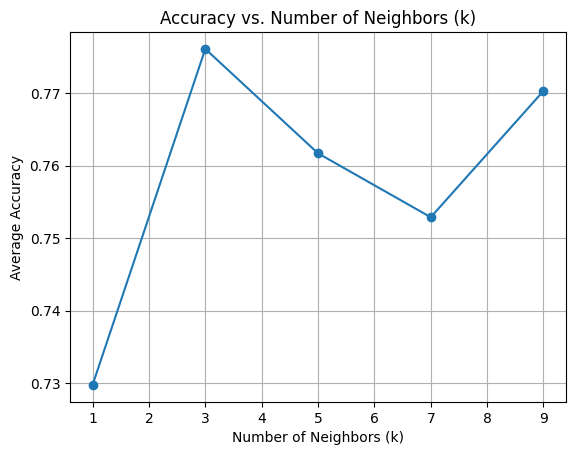

No Processing(cropped):
Best k: 3, Best Accuracy: 0.8053282182438192
Validation Accuracy: 0.7790697674418605


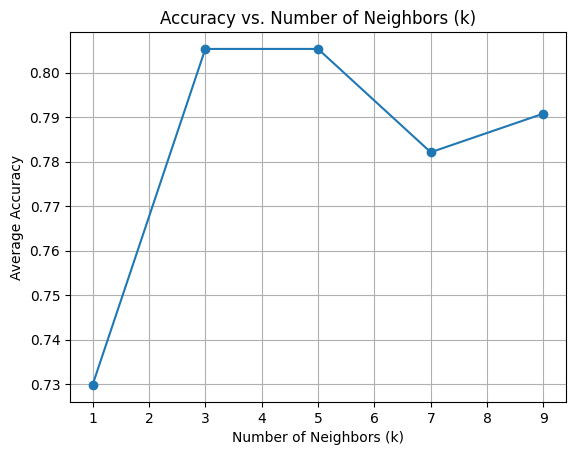

HOG Processing:
Best k: 9, Best Accuracy: 0.7789002557544757
Validation Accuracy: 0.7441860465116279


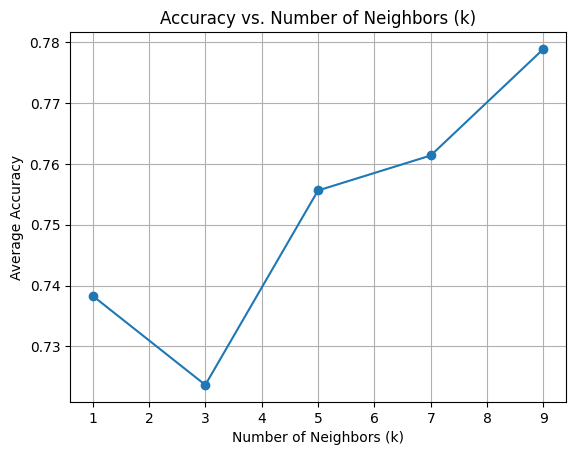

HOG Processing(cropped):
Best k: 5, Best Accuracy: 0.8170502983802216
Validation Accuracy: 0.813953488372093


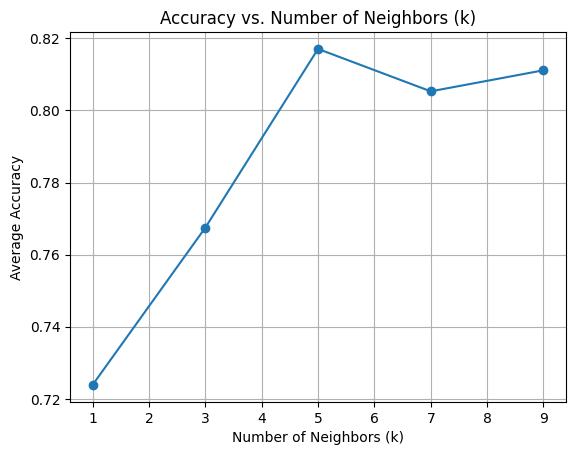

SIFT Processing:
Best k: 3, Best Accuracy: 0.7761295822676896
Validation Accuracy: 0.8023255813953488


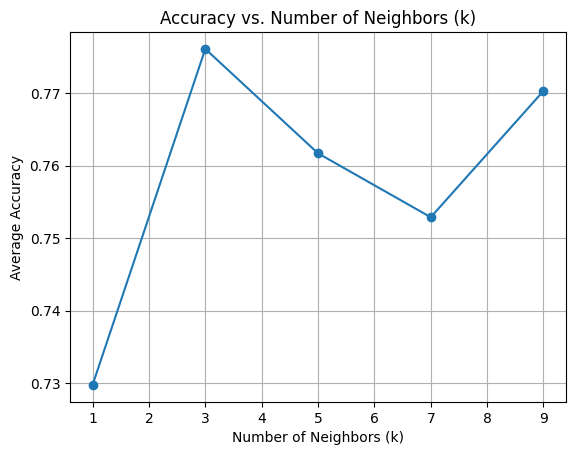

SIFT Processing(cropped):
Best k: 3, Best Accuracy: 0.8053282182438192
Validation Accuracy: 0.7790697674418605


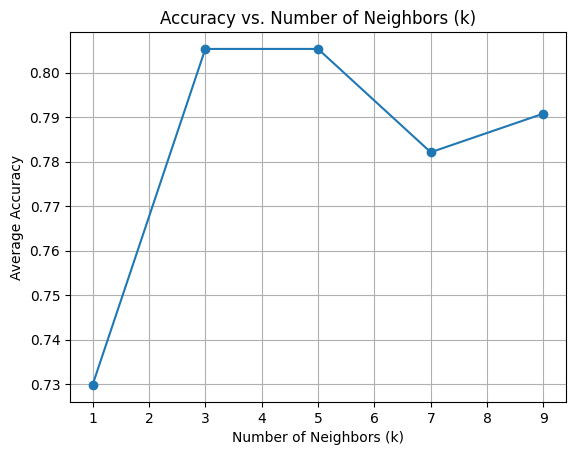

In [ ]:
print("No Processing:")
check_k_value(X_train, X_val, y_train, y_val)
print("No Processing(cropped):")
check_k_value(X_train_cropped, X_val_cropped, y_train_cropped, y_val_cropped)
print("HOG Processing:")
check_k_value(X_train_hog, X_val_hog, y_train_hog, y_val_hog)
print("HOG Processing(cropped):")
check_k_value(X_train_cropped_hog, X_val_cropped_hog, y_train_cropped_hog, y_val_cropped_hog)
print("SIFT Processing:")
check_k_value(X_train_sift, X_val_sift, y_train_sift, y_val_sift )
print("SIFT Processing(cropped):")
check_k_value(X_train_cropped_sift, X_val_cropped_sift, y_train_cropped_sift, y_val_cropped_sift)




## KNN Modeling

In [ ]:

def knn_model(dataset, labels, num_folds=5, k_neighbors=5):
    # Create K-Fold cross-validation object
    kf = KFold(n_splits=num_folds, shuffle=True)

    # Initialize lists to store accuracy and confusion matrices for each fold
    accuracies = []
    conf_matrices = []

    # Perform K-Fold cross-validation
    for train_index, val_index in kf.split(dataset):
        X_train_fold, X_val_fold = dataset[train_index], dataset[val_index]
        y_train_fold, y_val_fold = labels[train_index], labels[val_index]

        # Create the KNN classifier with specified number of neighbors
        knn = KNeighborsClassifier(n_neighbors=k_neighbors)

        # Train the classifier on the current fold of training data
        knn.fit(X_train_fold, y_train_fold)

        # Make predictions on the validation data
        y_pred_fold = knn.predict(X_val_fold)

        # Calculate the accuracy of the model for this fold
        accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
        accuracies.append(accuracy_fold)

        # Calculate the confusion matrix for this fold
        conf_matrix_fold = confusion_matrix(y_val_fold, y_pred_fold)
        conf_matrices.append(conf_matrix_fold)

    # Calculate the average accuracy and confusion matrix over all folds
    average_accuracy = np.mean(accuracies)
    total_conf_matrix = np.sum(conf_matrices, axis=0)

    print("Average Accuracy:", average_accuracy)
    print("Total Confusion Matrix:")
    print(total_conf_matrix)

    return average_accuracy, average_conf_matrix



In [ ]:
print("\nUncropped No Processing:")
knn_model(dataset, labels,3 )
print("\ncropped No Processing")
knn_model(dataset_cropped, labels_cropped,3)
print("\nUncropped Hog Processing")
knn_model(np.array(dataset_hog), labels_hog, 9)
print("\ncropped  Hog Processing")
knn_model(np.array(dataset_cropped_hog), labels_cropped_hog,5)
print("\nUncropped SIFT Processing")
knn_model(np.array(dataset_sift), labels_sift,3)
print("\ncropped  SIFT Processing")
knn_model(np.array(dataset_cropped_sift), labels_cropped_sift,3)


Uncropped No Processing:
Average Accuracy: 0.7698620823620823
Total Confusion Matrix:
[[199  51]
 [ 48 132]]

cropped No Processing
Average Accuracy: 0.7837347837347837
Total Confusion Matrix:
[[207  43]
 [ 50 130]]

Uncropped Hog Processing
Average Accuracy: 0.7930949566587864
Total Confusion Matrix:
[[175  75]
 [ 14 166]]

cropped  Hog Processing
Average Accuracy: 0.7790697674418605
Total Confusion Matrix:
[[169  81]
 [ 14 166]]

Uncropped SIFT Processing
Average Accuracy: 0.79998704998705
Total Confusion Matrix:
[[207  43]
 [ 43 137]]

cropped  SIFT Processing
Average Accuracy: 0.8093434343434344
Total Confusion Matrix:
[[217  33]
 [ 49 131]]


(0.8093434343434344,
 array([[42. ,  8. ],
        [ 9.4, 26.6]]))